# Temperature Scaling in Softmax: The Mathematics

Temperature scaling modifies the softmax function to control the "sharpness" of the probability distribution. The standard softmax function is:

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

With temperature scaling, we introduce a temperature parameter $T$:

$$\text{softmax}_T(x_i) = \frac{e^{x_i/T}}{\sum_{j=1}^{n} e^{x_j/T}}$$

## Effects of Temperature:

- **T = 1**: Standard softmax (no scaling)
- **T > 1**: Higher temperature → More uniform distribution → More randomness
- **T < 1**: Lower temperature → Sharper distribution → More deterministic
- **T → 0**: Distribution becomes one-hot (argmax)
- **T → ∞**: Distribution becomes uniform

## Entropy and Diversity:
The entropy of a probability distribution measures its randomness:
$$H(p) = -\sum_{i=1}^{n} p_i \log p_i$$

Higher temperature typically leads to higher entropy and more diverse outputs.

## Imports and Setup

Let's import the necessary libraries and set up our environment:

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from scipy.stats import entropy

# Rich imports for better formatting
from rich.console import Console
from rich.table import Table
from rich.text import Text
from rich import print as rprint

# Initialize rich console
console = Console()

All necessary libraries loaded for language modeling, visualization, and rich formatting.

## Visual Demonstration

Let's create a visual diagram showing how temperature affects probability distributions:

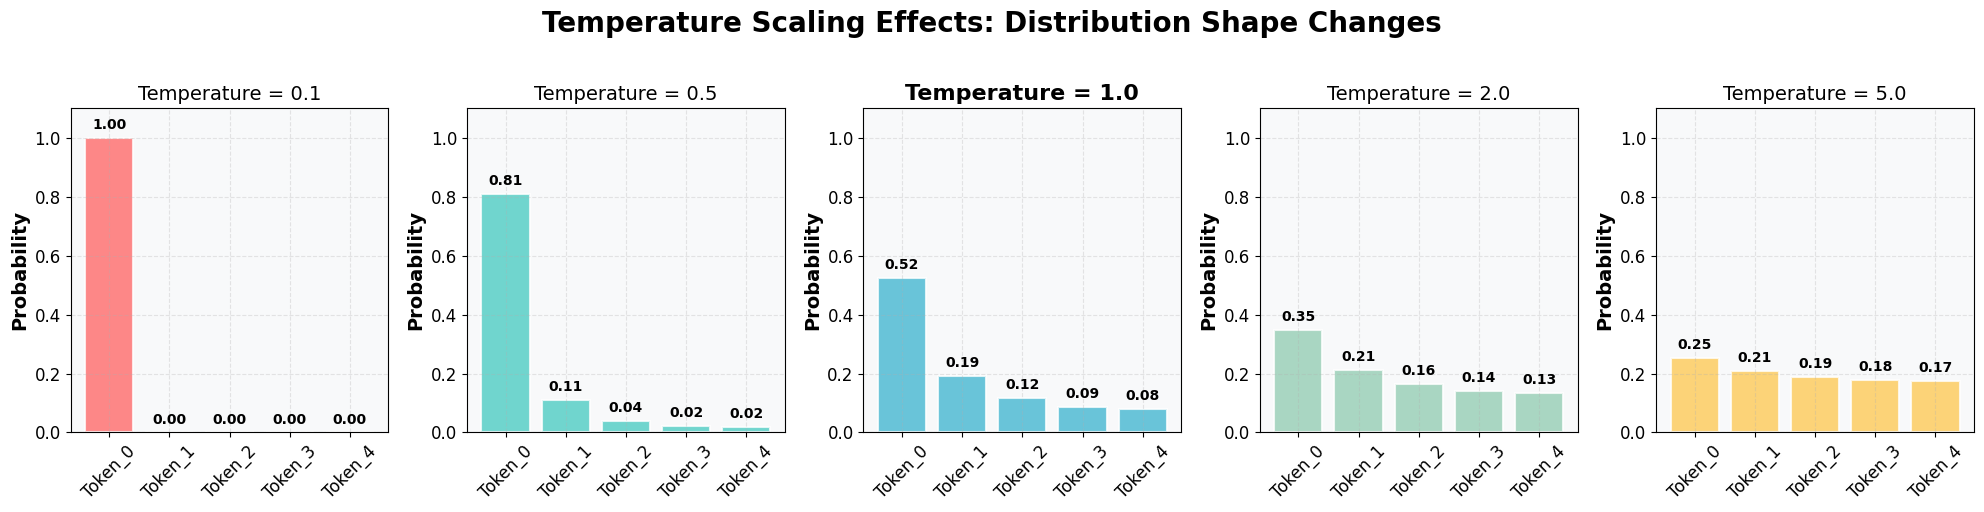

In [2]:
# Set up prettier matplotlib styling
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Create sample logits and temperature ranges
logits = np.array([2.0, 1.0, 0.5, 0.2, 0.1])
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]

# Create subplots with better styling
fig, axes = plt.subplots(1, len(temperatures), figsize=(20, 5))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

for i, temp in enumerate(temperatures):
    # Calculate probabilities for this temperature
    scaled_logits = logits / temp
    probs = np.exp(scaled_logits) / np.sum(np.exp(scaled_logits))
    
    # Create DataFrame for this temperature
    df_temp = pd.DataFrame({
        'Token': [f'Token_{j}' for j in range(len(logits))],
        'Probability': probs
    })
    
    # Plot distribution with better styling
    bars = axes[i].bar(df_temp['Token'], df_temp['Probability'], 
                      color=colors[i], alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # Bold T=1.0
    title_weight = 'bold' if temp == 1.0 else 'normal'
    title_size = 16 if temp == 1.0 else 14
    axes[i].set_title(f'Temperature = {temp}', fontweight=title_weight, fontsize=title_size)
    
    axes[i].set_ylabel('Probability', fontweight='bold')
    axes[i].set_ylim(0, 1.1)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3, linestyle='--')
    axes[i].set_facecolor('#F8F9FA')
    
    # Add probability values on top of bars
    for bar, prob in zip(bars, probs):
        axes[i].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                    f'{prob:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Temperature Scaling Effects: Distribution Shape Changes', 
            fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

This diagram clearly shows how temperature reshapes probability distributions - low temperatures create peaked distributions while high temperatures flatten them.

## Model Setup

Load a language model to explore temperature effects in practice:

In [3]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Set padding token to avoid warnings
tokenizer.pad_token = tokenizer.eos_token

DistilGPT2 loaded with proper tokenizer configuration.

## Example Prompt

Let's start with a simple prompt to analyze:

In [4]:
prompt = "In the future, AI will"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
print("Input IDs:", input_ids)
print("Vocabulary size:", model.config.vocab_size)

Input IDs: tensor([[ 818,  262, 2003,   11, 9552,  481]])
Vocabulary size: 50257


The model converts text to token IDs and works with a vocabulary of 50,257 tokens.

## Text Generation with Low Temperature

Generate text with very low temperature to see deterministic behavior:

In [5]:
output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.01,
    max_new_tokens=20,
    top_k=50,
    pad_token_id=tokenizer.eos_token_id,
    attention_mask=torch.ones_like(input_ids)
)

decoded = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated text:", decoded)

Generated text: In the future, AI will be able to do things like make people smarter, more intelligent, more intelligent, more intelligent, more


Low temperature produces repetitive, deterministic text.

## Logits Analysis

Let's examine the raw logits and probabilities for next token prediction:

In [6]:
# Get the logits for prediction
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits
    # Show logits and probabilities for top 10 tokens
    top_logits, top_indices = torch.topk(logits[0, -1], k=10)
    top_probs = torch.softmax(top_logits, dim=0)
    top_tokens = [tokenizer.decode([idx]) for idx in top_indices]
    
    # Create a clean table
    table = Table(title="Top 10 Token Predictions")
    table.add_column("Rank", style="dim")
    table.add_column("Token", style="cyan")
    table.add_column("Logit", style="magenta")
    table.add_column("Probability", style="green")
    
    for i, (token, logit, prob) in enumerate(zip(top_tokens, top_logits, top_probs)):
        table.add_row(
            str(i + 1),
            repr(token),
            f"{logit.item():.4f}",
            f"{prob.item():.4f}"
        )
    
    console.print(table)

           Top 10 Token Predictions            
┏━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Rank ┃ Token       ┃ Logit    ┃ Probability ┃
┡━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 1    │ ' be'       │ -63.5934 │ 0.5269      │
│ 2    │ ' have'     │ -64.7306 │ 0.1690      │
│ 3    │ ' need'     │ -65.5254 │ 0.0763      │
│ 4    │ ' become'   │ -65.8555 │ 0.0549      │
│ 5    │ ' not'      │ -66.0847 │ 0.0436      │
│ 6    │ ' also'     │ -66.4207 │ 0.0312      │
│ 7    │ ' take'     │ -66.5617 │ 0.0271      │
│ 8    │ ' continue' │ -66.5808 │ 0.0266      │
│ 9    │ ' make'     │ -66.6369 │ 0.0251      │
│ 10   │ ' only'     │ -66.8984 │ 0.0193      │
└──────┴─────────────┴──────────┴─────────────┘

The model shows clear preference for certain tokens, with "be" having the highest probability.

## Token Sampling

Sample tokens from the probability distribution to see randomness in action:

In [7]:
# Sample tokens from the distribution
sampled_indices = torch.multinomial(top_probs, num_samples=100, replacement=True)
sampled_tokens = [top_tokens[idx] for idx in sampled_indices]

# Display sample using Rich
rprint("Sample of tokens:")
rprint(" ".join([f"[cyan]{token}[/cyan]" for token in sampled_tokens[:20]]))

# Count occurrences and display in Rich table
token_counts = Counter(sampled_tokens)

# Create Rich table for token counts
table = Table(title="Token Counts from 100 Samples")
table.add_column("Token", style="cyan")
table.add_column("Count", style="green")
table.add_column("Percentage", style="yellow")

for token, count in token_counts.most_common():
    percentage = (count / 100) * 100
    table.add_row(token, str(count), f"{percentage:.1f}%")

console.print(table)

Sample of tokens:

 be  make  make  be  not  have  become  be  have  have  have  be  be  need  become  need  also  be  also  be

  Token Counts from 100 Samples   
┏━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ Token     ┃ Count ┃ Percentage ┃
┡━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│  be       │ 53    │ 53.0%      │
│  have     │ 16    │ 16.0%      │
│  become   │ 9     │ 9.0%       │
│  need     │ 9     │ 9.0%       │
│  also     │ 4     │ 4.0%       │
│  make     │ 3     │ 3.0%       │
│  not      │ 2     │ 2.0%       │
│  take     │ 2     │ 2.0%       │
│  continue │ 2     │ 2.0%       │
└───────────┴───────┴────────────┘

Token counts from 100 samples reflect the underlying probability distribution.

## Temperature Scaling Comparison

Compare extreme temperature values to see dramatic differences:

In [8]:
# Temperature scaling comparison across multiple temperatures
temperature_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 100.0]

# Calculate probabilities for each temperature
temp_results = {}
for temp in temperature_values:
    scaled_logits = logits / temp
    top_logits_temp, top_indices_temp = torch.topk(scaled_logits[0, -1], k=10)
    top_probs_temp = torch.softmax(top_logits_temp, dim=0)
    temp_results[temp] = {
        'probs': top_probs_temp,
        'tokens': [tokenizer.decode([idx]) for idx in top_indices_temp]
    }

# Create comprehensive comparison table
table = Table(title="Temperature Scaling: Full Spectrum Comparison")
table.add_column("Rank", style="dim")
table.add_column("Token", style="cyan")

for temp in temperature_values:
    if temp == 1.0:
        table.add_column(f"**T={temp}**", style="bold green")  # Bold T=1
    else:
        table.add_column(f"T={temp}", style="green" if temp > 1.0 else "red")

for i in range(10):
    row_data = [str(i + 1), repr(temp_results[temperature_values[0]]['tokens'][i])]
    
    for temp in temperature_values:
        prob = temp_results[temp]['probs'][i].item()
        row_data.append(f"{prob:.4f}")
    
    table.add_row(*row_data)

console.print(table)

                      Temperature Scaling: Full Spectrum Comparison                      
┏━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Rank ┃ Token       ┃ T=0.01 ┃ T=0.1  ┃ T=0.5  ┃ **T=1.0** ┃ T=2.0  ┃ T=5.0  ┃ T=100.0 ┃
┡━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ 1    │ ' be'       │ 1.0000 │ 1.0000 │ 0.8667 │ 0.5269    │ 0.2731 │ 0.1550 │ 0.1023  │
│ 2    │ ' have'     │ 0.0000 │ 0.0000 │ 0.0891 │ 0.1690    │ 0.1547 │ 0.1235 │ 0.1012  │
│ 3    │ ' need'     │ 0.0000 │ 0.0000 │ 0.0182 │ 0.0763    │ 0.1039 │ 0.1053 │ 0.1004  │
│ 4    │ ' become'   │ 0.0000 │ 0.0000 │ 0.0094 │ 0.0549    │ 0.0881 │ 0.0986 │ 0.1000  │
│ 5    │ ' not'      │ 0.0000 │ 0.0000 │ 0.0059 │ 0.0436    │ 0.0786 │ 0.0942 │ 0.0998  │
│ 6    │ ' also'     │ 0.0000 │ 0.0000 │ 0.0030 │ 0.0312    │ 0.0664 │ 0.0881 │ 0.0995  │
│ 7    │ ' take'     │ 0.0000 │ 0.0000 │ 0.0023 │ 0.0271    │ 0.0619 │ 0.0856 │ 0.0993  │
│ 8    │ ' continue' │ 0.0000 │ 0.0000 │ 0.0022 │ 0.0266    │ 0.0613 │ 0.0853 │ 0.0993  │
│ 9    │ ' make'     │ 0.0000 │ 0.0000 │ 0.0020 │ 0.0251    │ 0.0596 │ 0.0843 │ 0.0992  │
│ 10   │ ' only'     │ 0.0000 │ 0.0000 │ 0.0012 │ 0.0193    │ 0.0523 │ 0.0800 │ 0.0990  │
└──────┴─────────────┴────────┴────────┴────────┴───────────┴────────┴────────┴─────────┘

High temperature creates uniform distribution while low temperature creates deterministic selection.

## Temperature Analysis

Analyze how different temperatures affect probability distributions and entropy:

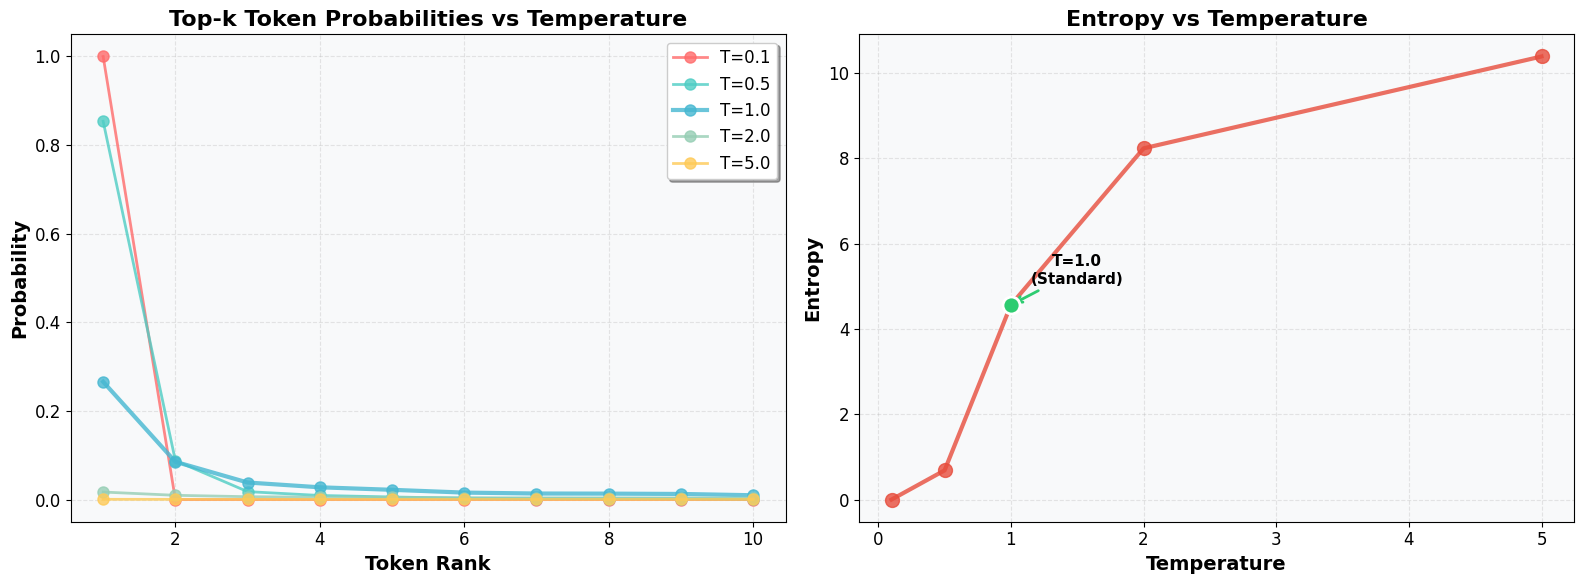

In [9]:
# Function to analyze temperature effects
def analyze_temperature_effects(logits, temperatures, top_k=10):
    results = []
    for temp in temperatures:
        scaled_logits = logits / temp
        probs = torch.softmax(scaled_logits, dim=-1)
        
        # Get top-k tokens
        top_probs, top_indices = torch.topk(probs[0, -1], k=top_k)
        top_tokens = [tokenizer.decode([idx]) for idx in top_indices]
        
        # Calculate entropy
        prob_dist = probs[0, -1].cpu().numpy()
        entropy_value = entropy(prob_dist)
        
        for i, (token, prob) in enumerate(zip(top_tokens, top_probs)):
            results.append({
                'temperature': temp,
                'token': token,
                'probability': prob.item(),
                'rank': i + 1,
                'entropy': entropy_value
            })
    
    return results

# Test with different temperature values
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]
results = analyze_temperature_effects(logits, temperatures)

# Create prettier visualizations
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top-k probabilities with better styling
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
for i, temp in enumerate(temperatures):
    temp_data = [r for r in results if r['temperature'] == temp]
    ranks = [r['rank'] for r in temp_data]
    probs = [r['probability'] for r in temp_data]
    
    linewidth = 3 if temp == 1.0 else 2
    axes[0].plot(ranks, probs, 'o-', label=f'T={temp}', 
                color=colors[i], linewidth=linewidth, markersize=8, alpha=0.8)

axes[0].set_xlabel('Token Rank', fontweight='bold')
axes[0].set_ylabel('Probability', fontweight='bold')
axes[0].set_title('Top-k Token Probabilities vs Temperature', fontweight='bold')
axes[0].legend(frameon=True, fancybox=True, shadow=True)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_facecolor('#F8F9FA')

# Plot 2: Entropy vs Temperature with better styling
entropies = []
for temp in temperatures:
    temp_entropy = [r['entropy'] for r in results if r['temperature'] == temp][0]
    entropies.append(temp_entropy)

axes[1].plot(temperatures, entropies, 'o-', color='#E74C3C', 
            linewidth=3, markersize=10, alpha=0.8)
axes[1].set_xlabel('Temperature', fontweight='bold')
axes[1].set_ylabel('Entropy', fontweight='bold')
axes[1].set_title('Entropy vs Temperature', fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_facecolor('#F8F9FA')

# Highlight T=1.0 on entropy plot
idx_1 = temperatures.index(1.0)
axes[1].scatter(1.0, entropies[idx_1], color='#2ECC71', s=150, 
               zorder=5, edgecolors='white', linewidth=2)
axes[1].annotate('T=1.0\n(Standard)', xy=(1.0, entropies[idx_1]), 
                xytext=(1.5, entropies[idx_1] + 0.5),
                arrowprops=dict(arrowstyle='->', color='#2ECC71', lw=2),
                fontsize=11, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Higher temperatures lead to flatter distributions and higher entropy, confirming the mathematical relationship.

## Diverse Examples Across Domains

Test temperature effects on different types of content:

In [10]:
def generate_comparison_examples():
    """Generate examples across different domains to show temperature effects"""
    
    examples = [
        ("The scientific method involves", "Science"),
        ("To solve the equation x^2 - 4x + 3 = 0,", "Mathematics"),
        ("In Shakespeare's time, the theater", "Literature/English")
    ]
    
    temperatures = [0.3, 1.0, 2.0]
    
    for prompt, domain in examples:
        rprint(f"\n[bold]{domain.upper()}[/bold]")
        rprint(f"Prompt: '{prompt}'")
        rprint("-" * 50)
        
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        
        for temp in temperatures:
            rprint(f"\n[cyan]Temperature {temp}:[/cyan]")
            for i in range(3):  # Generate 3 samples per temperature
                output = model.generate(
                    input_ids,
                    do_sample=True,
                    temperature=temp,
                    max_new_tokens=15,
                    top_k=50,
                    pad_token_id=tokenizer.eos_token_id,
                    attention_mask=torch.ones_like(input_ids)
                )
                
                generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
                new_text = generated_text[len(prompt):].strip()
                rprint(f"  Sample {i+1}: {new_text}")
        
        print()

generate_comparison_examples()

SCIENCE

Prompt: 'The scientific method involves'

--------------------------------------------------

Temperature 0.3:

Sample 1: the use of a single, single, single, single-digit number.

Sample 2: a series of steps to achieve a specific goal. For example, the goal

Sample 3: taking a single molecule of a molecule of a molecule of a molecule of a

Temperature 1.0:

Sample 1: two elements: a measurement of the quality of the water and a measurement of

Sample 2: measuring the concentration of a large number of nucleic acids. (See a

Sample 3: measuring all sorts of atoms using two different atomic weights, called the ‴

Temperature 2.0:

Sample 1: some complicated equations such that the equations simply must exist before applying force. In

Sample 2: determining each set of biological pathways to change each phenotype based on that pathway.

Sample 3: using samples in real and made use of pure glass; with a special lens

MATHEMATICS

Prompt: 'To solve the equation x^2 - 4x + 3 = 0,'

--------------------------------------------------

Temperature 0.3:

Sample 1: 2x + 3 = 0, 2x + 3 = 0, 2

Sample 2: and then it is the same as x^2 + 4x + 4

Sample 3: x^2 - 4x + 3 = 0, x^2 -

Temperature 1.0:

Sample 1: 3x = 1, 4x = 2, 4x = 3,

Sample 2: 0 , and 1 )




The idea is simple.

Sample 3: but the answer at 1x is the same as with m^2 -

Temperature 2.0:

Sample 1: where * x=A.add(-10, 0 / B)

Sample 2: ‰

Sample 3: 4 ( \times f(-x)). Note the error of z(5

LITERATURE/ENGLISH

Prompt: 'In Shakespeare's time, the theater'

--------------------------------------------------

Temperature 0.3:

Sample 1: was a kind of theater, a kind of theater, a kind of theater

Sample 2: was a place where people could play Shakespeare and Shakespeare. The theater was a

Sample 3: was a kind of theater where the audience could see the characters and the characters

Temperature 1.0:

Sample 1: is a work of art and creativity.


He and his wife

Sample 2: and the music are also known for using Shakespeare's "soul with him

Sample 3: 's most famous poet, Thomas Edison, drew its light on his favorite verse

Temperature 2.0:

Sample 1: troupe was founded by British writer Stephen King at around that stage. Here

Sample 2: might have had better management because of the lack of quality of production at a

Sample 3: director himself had, as Sir Francis Molloy had hinted about a �

Multiple samples reveal consistency patterns at low temperatures and diversity at high temperatures across all domains.

# Practical Applications

## Use Cases
- **Low Temperature (0.1-0.5)**: Code generation, technical docs, factual content
- **Medium Temperature (0.7-1.2)**: Creative writing, chatbots, general text
- **High Temperature (1.5-3.0)**: Brainstorming, fiction, diverse idea generation

## Quick Guidelines
- Start with T=1.0 as baseline
- Lower temperature for consistency and accuracy
- Higher temperature for creativity and diversity

# Conclusion

Temperature scaling is a simple yet powerful technique for controlling language model randomness:

- **T < 1**: More deterministic, consistent outputs
- **T = 1**: Standard softmax behavior  
- **T > 1**: More random, diverse outputs

Monitor entropy to quantify diversity. Temperature remains one of the most practical tools for controlling LLM behavior.

# References

## Code and Implementation
- Temperature Scaling Repository: https://github.com/gpleiss/temperature_scaling
- Twitter Discussion: https://x.com/akshay_pachaar/status/1942201076767412307

## Academic Sources
- Hinton, G. et al. (2015): "Distilling the Knowledge in a Neural Network" - Original paper introducing temperature in knowledge distillation
- Guo, C. et al. (2017): "On Calibration of Modern Neural Networks" - ICML paper on temperature scaling for calibration
- Goodfellow, I. et al. (2016): "Deep Learning" - Chapter 6 covers softmax and temperature scaling
- Bishop, C. (2006): "Pattern Recognition and Machine Learning" - Chapter 4 discusses softmax temperature

## Textbooks
- "Deep Learning" by Goodfellow, Bengio, and Courville - Comprehensive coverage of softmax and sampling techniques
- "Pattern Recognition and Machine Learning" by Christopher Bishop - Mathematical foundations of probability distributions
- "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman - Statistical perspective on temperature scaling